STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# Character RNN

A simple character-level RNN to generate new bits of text based on text.

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch,torchtext

import time
import random
import unidecode
import string
import re

import matplotlib.pyplot as plt
import torch

torch.backends.cudnn.deterministic = True

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

torch    : 1.8.0
torchtext: 0.10.0a0+d2a0776



## General Settings

In [2]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device('cpu')

TEXT_PORTION_SIZE = 200

NUM_ITER = 5000
LEARNING_RATE = 0.005
EMBEDDING_DIM = 100
HIDDEN_DIM = 128

print('Device:', DEVICE)

Device: cpu


## Dataset

Convert all characters into ASCII characters provided by `string.printable`:

In [5]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [6]:
with open('covid19-faq.txt', 'r') as f:
    textfile = f.read()

# convert special characters
textfile = unidecode.unidecode(textfile)

# strip extra whitespaces
textfile = re.sub(' +',' ', textfile)

TEXT_LENGTH = len(textfile)

print(f'Number of characters in text: {TEXT_LENGTH}')

Number of characters in text: 84658


Divide the text into smaller portions:

In [7]:
random.seed(RANDOM_SEED)

def random_portion(textfile):
    start_index = random.randint(0, TEXT_LENGTH - TEXT_PORTION_SIZE)
    end_index = start_index + TEXT_PORTION_SIZE + 1
    return textfile[start_index:end_index]

print(random_portion(textfile))

heck with the vaccine provider.

If you're traveling away from Madison before your second dose, we encourage you to get your first dose on campus now and obtain a second dose once you reach your new lo


Define a function to convert characters into tensors of integers (type long):


In [8]:
def char_to_tensor(text):
    lst = [string.printable.index(c) for c in text]
    tensor = torch.tensor(lst).long()
    return tensor

print(char_to_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Putting it together to make a function that draws random batches for training:

In [9]:
def draw_random_sample(textfile):    
    text_long = char_to_tensor(random_portion(textfile))
    inputs = text_long[:-1]
    targets = text_long[1:]
    return inputs, targets

In [10]:
draw_random_sample(textfile)

(tensor([ 0, 94, 24, 27, 94, 21, 10, 29, 14, 27, 94, 24, 15, 94, 26, 30, 10, 27,
         10, 23, 29, 18, 23, 14, 94, 10, 23, 13, 94, 34, 24, 30, 27, 94, 37, 10,
         13, 16, 14, 27, 94, 37, 10, 13, 16, 14, 94, 18, 23, 13, 18, 12, 10, 29,
         14, 28, 94, 63, 11, 30, 18, 21, 13, 18, 23, 16, 94, 10, 12, 12, 14, 28,
         28, 94, 16, 27, 10, 23, 29, 14, 13, 75, 63, 96, 54, 14, 14, 94, 29, 17,
         14, 94, 56, 23, 18, 31, 14, 27, 28, 18, 29, 34, 94, 43, 14, 10, 21, 29,
         17, 94, 54, 14, 27, 31, 18, 12, 14, 28, 94, 32, 14, 11, 28, 18, 29, 14,
         94, 15, 24, 27, 94, 22, 24, 27, 14, 94, 18, 23, 15, 24, 27, 22, 10, 29,
         18, 24, 23, 94, 10, 11, 24, 30, 29, 94, 26, 30, 10, 27, 10, 23, 29, 18,
         23, 14, 94, 10, 23, 13, 94, 18, 28, 24, 21, 10, 29, 18, 24, 23, 75, 96,
         96, 58, 17, 18, 21, 14, 94,  1,  4, 94, 13, 10, 34, 28, 94, 18, 28, 94,
         29, 17]),
 tensor([94, 24, 27, 94, 21, 10, 29, 14, 27, 94, 24, 15, 94, 26, 30, 10, 27, 10,
         

## Model

In [11]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, embed_size,
                 hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size
        
        self.embed = torch.nn.Embedding(num_embeddings=input_size,
                                        embedding_dim=embed_size)
        self.rnn = torch.nn.LSTMCell(input_size=embed_size,
                                     hidden_size=hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, character, hidden, cell_state):
        # expects character as size [batch_size, 1]
    
        # [batch size, embedding dim] = [1, embedding dim]
        embedded = self.embed(character)

        (hidden, cell_state) = self.rnn(embedded, (hidden, cell_state))
        # 1. output dim: [batch size, output_size] = [1, output_size]
        # 2. hidden dim: [batch size, hidden dim] = [1, hidden dim]
        # 3. cell dim: [batch size, hidden dim] = [1, hidden dim]

        output = self.fc(hidden)

        return output, hidden, cell_state
      
    def init_zero_state(self):
        init_hidden = torch.zeros(1, self.hidden_size).to(DEVICE)
        init_cell = torch.zeros(1, self.hidden_size).to(DEVICE)
        return (init_hidden, init_cell)

In [12]:
torch.manual_seed(RANDOM_SEED)
model = RNN(len(string.printable), EMBEDDING_DIM, HIDDEN_DIM, len(string.printable))
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [13]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    ## based on https://github.com/spro/practical-pytorch/
    ## blob/master/char-rnn-generation/char-rnn-generation.ipynb

    (hidden, cell_state) = model.init_zero_state()
    prime_input = char_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        inp = prime_input[p].unsqueeze(0)
        _, hidden, cell_state = model(inp.to(DEVICE), hidden, cell_state)
    inp = prime_input[-1].unsqueeze(0)
    
    for p in range(predict_len):

        outputs, hidden, cell_state = model(inp.to(DEVICE), hidden, cell_state)
        
        # Sample from the network as a multinomial distribution
        output_dist = outputs.data.view(-1).div(temperature).exp() # e^{logits / T}
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = string.printable[top_i]
        predicted += predicted_char
        inp = char_to_tensor(predicted_char)

    return predicted

Time elapsed: 0.00 min
Iteration 0 | Loss 4.63


ThA
C8(_NWmsdcrx~
AGq40uWn"?LY"B5Ckl]7C~=	R
n&u8Wor*K\/=u;+M0|~@]2Lq
pYn^.06Bv	K=Uqv:3Wmw`^C!OUMY
K7;&eHG{_K
 (#=uF+Rn%%nzh*`w'f+31:2zMiS!SV/nZu<]3>EoI!Rb*M,f`:M]r]*jkgUQVgO=nJ_CM1q

Time elapsed: 0.19 min
Iteration 200 | Loss 2.08


The cablici mestainal the al coplity your be and ants doy haplate rentranty resil the to stunts pare the the antain untd yout als the resest in will Cuke bition expouts gill fallern in vafinite ap and a 

Time elapsed: 0.38 min
Iteration 400 | Loss 2.07


The need wrew working this the for procting whorving test eadind comployeeallo neeftted by impust as sprocal wollan app becore the sullen to so feding to be entrend will be entrant the have will to noth 

Time elapsed: 0.57 min
Iteration 600 | Loss 1.76


Th us will beppa required a remative to student a restment reture an tive vadgers ass a to students. Sturtivise onst reasing to live you's of a regatrivating haschat a campus and gat is prividuration on

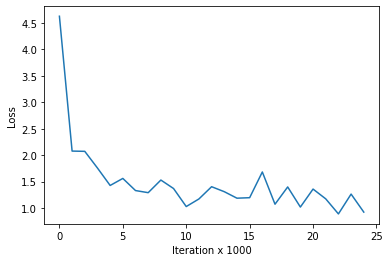

In [14]:
start_time = time.time()

loss_list = []

for iteration in range(NUM_ITER):

    hidden, cell_state = model.init_zero_state()
    optimizer.zero_grad()
    
    loss = 0.
    inputs, targets = draw_random_sample(textfile)
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    
    for c in range(TEXT_PORTION_SIZE):
        outputs, hidden, cell_state = model(inputs[c].unsqueeze(0), hidden, cell_state)
        loss += torch.nn.functional.cross_entropy(outputs, targets[c].view(1))

    loss /= TEXT_PORTION_SIZE
    loss.backward()
    
    ### UPDATE MODEL PARAMETERS
    optimizer.step()

    ### LOGGING
    with torch.no_grad():
        if iteration % 200 == 0:
            print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
            print(f'Iteration {iteration} | Loss {loss.item():.2f}\n\n')
            print(evaluate(model, 'Th', 200), '\n')
            print(50*'=')
            
            loss_list.append(loss.item())
            plt.clf()
            plt.plot(range(len(loss_list)), loss_list)
            plt.ylabel('Loss')
            plt.xlabel('Iteration x 1000')
            plt.savefig('loss1.pdf')
            
plt.clf()
plt.ylabel('Loss')
plt.xlabel('Iteration x 1000')
plt.plot(range(len(loss_list)), loss_list)
plt.show()